# Loan Data Classification 
The Loan Data Classification project aims to leverage machine learning to predict the likelihood of loan defaults, a critical task for financial institutions seeking to manage risk effectively. Using historical loan data, this binary classification problem focuses on distinguishing between loans that are likely to be repaid and those at risk of default. By analyzing features such as borrower demographics, credit history, loan amount, and repayment terms, the model provides valuable insights to support decision-making in loan approvals and risk assessment. This project not only demonstrates the application of predictive analytics in finance but also emphasizes the importance of data-driven approaches in optimizing lending strategies.

This project focuses on building and evaluating machine learning models to address classification tasks, with a particular emphasis on handling imbalanced datasets. Utilizing Python's powerful data analysis and machine learning libraries, the project combines exploratory data analysis, preprocessing, and advanced modeling techniques. Key steps include visualizing data patterns with Seaborn and Matplotlib, scaling features using MinMaxScaler, and addressing class imbalances through synthetic oversampling with SMOTE. The models employed—Random Forest Classifier, Support Vector Classifier (SVC), and K-Nearest Neighbors (KNN)—are trained and tested using a systematic approach involving train-test splits and rigorous performance evaluation metrics such as F1 scores, accuracy, and confusion matrices. This pipeline ensures robust, interpretable results, suitable for real-world classification challenges.

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import numpy as np

Importing the dataset using pandas

In [2]:
dataset = pd.read_csv("loan_data.csv")

dataset.shape

(45000, 14)

Description of the dataset

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

Plotting the distribution of numerical features from the dataset

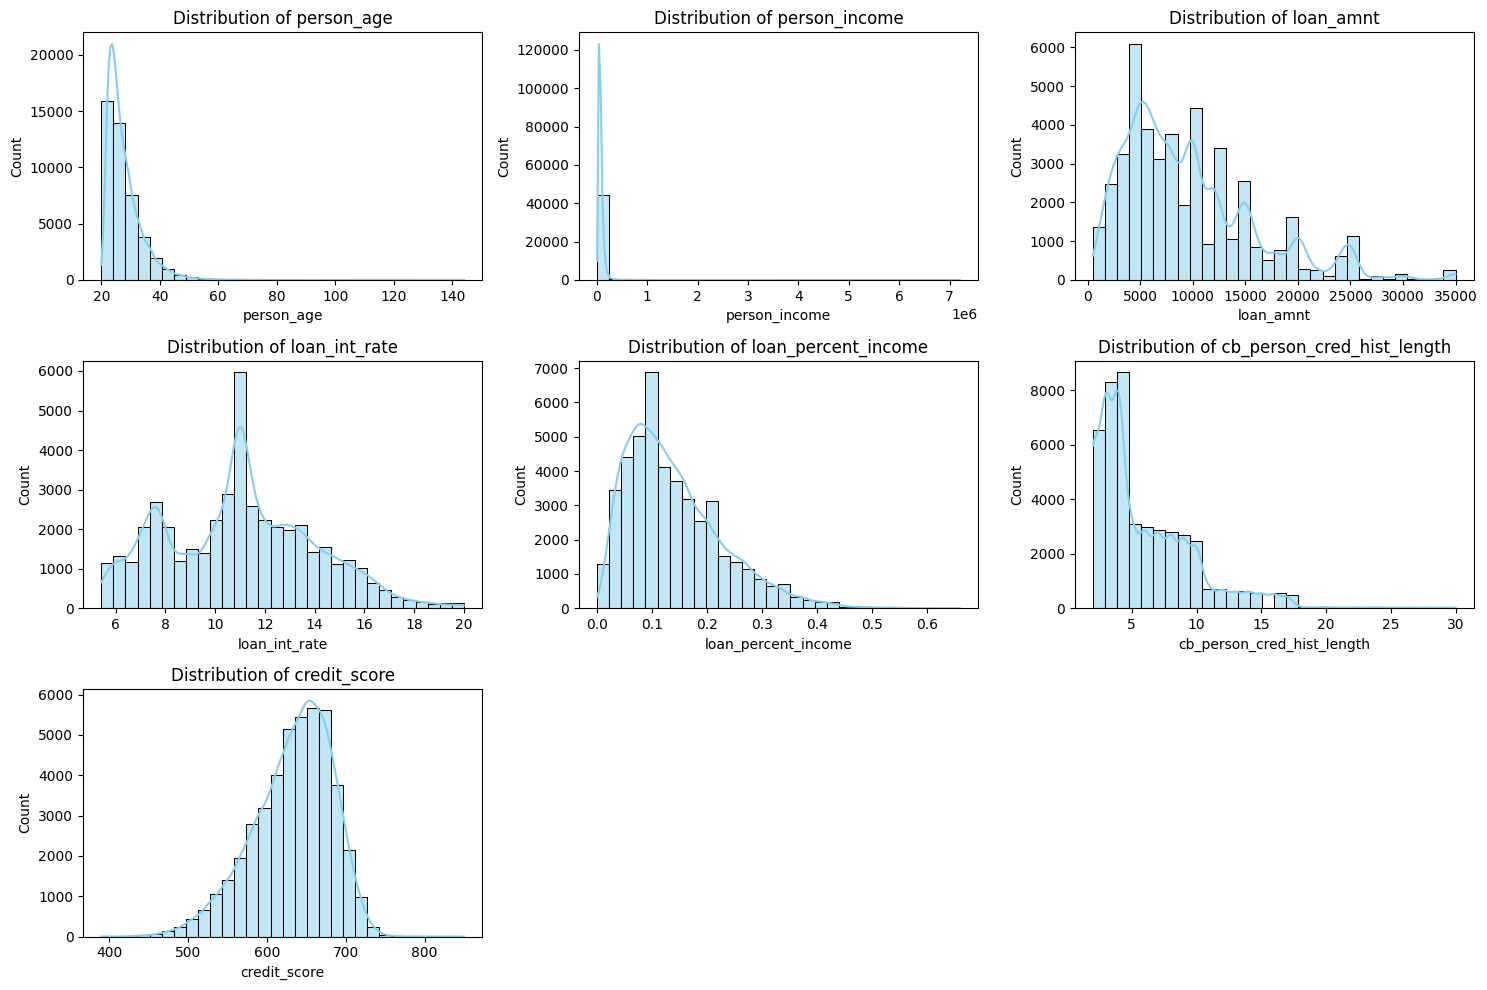

In [4]:
numeric_features = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Plot each numeric feature
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)  # Create subplots
    sns.histplot(dataset[feature], kde=True, bins=30, color='skyblue')  # KDE plot for smoothness
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

In [5]:
dataset.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


This means that the dataset is imbalanced containing more class 0 data than class 1 data i.e. the data contains 35,000 samples for class 0 data and 10,000 samples for the class 1 data. 

In [6]:
loan_statuses = dataset["loan_status"].value_counts()

loan_statuses

loan_status
0    35000
1    10000
Name: count, dtype: int64

Visualizing the imbalance in a pie chart to see the distribution

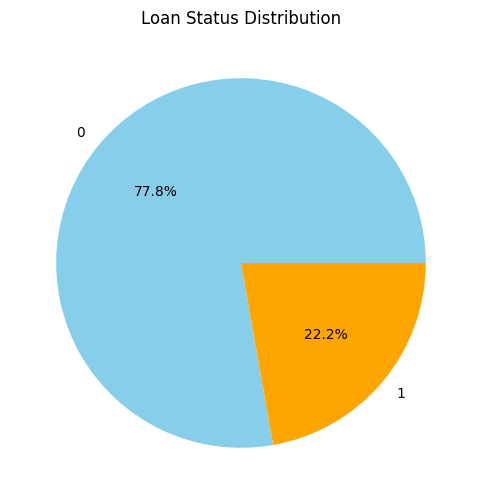

In [7]:
plt.figure(figsize=(6, 4))
loan_statuses.plot.pie(autopct='%1.1f%%', colors=['skyblue', 'orange'], figsize=(6, 6))
plt.title('Loan Status Distribution')
plt.ylabel('')
plt.show()

Splitting the data into input features and output targets

In [8]:
X = dataset.drop(columns="loan_status")
y = dataset["loan_status"]

X.shape, y.shape

((45000, 13), (45000,))

Now the data is not yet ready for training. We need to first normalize and deal with categorical values first

In [31]:
X.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score
count,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,0.062614,0.010054,0.043283,0.263280,0.383169,0.211704,0.138125,0.527410
std,0.048751,0.011181,0.048508,0.183040,0.204308,0.132140,0.138561,0.109643
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.032258,0.005450,0.008000,0.130435,0.217421,0.106061,0.035714,0.458696
50%,0.048387,0.008209,0.032000,0.217391,0.383402,0.181818,0.071429,0.543478
75%,0.080645,0.012205,0.064000,0.340210,0.519204,0.287879,0.214286,0.608696
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


First we will see which columns contain the categorical data and what contain numerical data.

In [10]:
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical Columns:", categorical_columns)
print("Numerical Columns:", numerical_columns)

Categorical Columns: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Numerical Columns: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']


The dataset does not contain any missing data as we see the sum of the all null values in each column is 0

In [11]:
X.isnull().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
dtype: int64

We will use MixMaxScaler to normalize the data elements in a certain range so that the impact of each entry is normalized.

In [12]:
scaler = MinMaxScaler()

X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

X.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file
0,0.016129,female,Master,0.008891,0.000,RENT,1.000000,PERSONAL,0.727023,0.742424,0.035714,0.371739,No
1,0.008065,female,High School,0.000595,0.000,OWN,0.014493,EDUCATION,0.392318,0.121212,0.000000,0.247826,Yes
2,0.040323,female,High School,0.000617,0.024,MORTGAGE,0.144928,MEDICAL,0.510974,0.666667,0.035714,0.532609,No
3,0.024194,female,Bachelor,0.009976,0.000,RENT,1.000000,MEDICAL,0.672840,0.666667,0.000000,0.619565,No
4,0.032258,male,Master,0.008082,0.008,RENT,1.000000,MEDICAL,0.606996,0.803030,0.071429,0.426087,No


We now deal with categorical values by one hot encoding 

In [13]:
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

X.head()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,person_gender_male,person_education_Bachelor,...,person_education_Master,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes
0,0.016129,0.008891,0.000,1.000000,0.727023,0.742424,0.035714,0.371739,False,False,...,True,False,False,True,False,False,False,True,False,False
1,0.008065,0.000595,0.000,0.014493,0.392318,0.121212,0.000000,0.247826,False,False,...,False,False,True,False,True,False,False,False,False,True
2,0.040323,0.000617,0.024,0.144928,0.510974,0.666667,0.035714,0.532609,False,False,...,False,False,False,False,False,False,True,False,False,False
3,0.024194,0.009976,0.000,1.000000,0.672840,0.666667,0.000000,0.619565,False,True,...,False,False,False,True,False,False,True,False,False,False
4,0.032258,0.008082,0.008,1.000000,0.606996,0.803030,0.071429,0.426087,True,False,...,True,False,False,True,False,False,True,False,False,False


The resultant dataset after preprocessing contains 22 columns with 45,000 samples

In [14]:
X.shape

(45000, 22)

In order to deal with the imbalance in the dataset, Synthetic Minority Oversampling Technique (SMOTE) which generates synthetic samples for the minority class. As a result of which the dataset now consists of 70,000 samples

In [15]:
smote = SMOTE(random_state=42)

X_balanced, y_balanced = smote.fit_resample(X, y)

X_balanced.shape, y_balanced.shape

((70000, 22), (70000,))

The `train_models` function is designed to automate the training and evaluation of multiple machine learning models. By accepting a list of models, a dataset, and target labels as input, it streamlines the process of model training, testing, and performance assessment. The function begins by splitting the data into training and testing sets, ensuring reproducibility with a fixed random state. Each model in the input list is trained on the training data and used to predict outcomes on the test set. The results are evaluated using metrics such as accuracy, F1 score, and a confusion matrix, providing a comprehensive performance summary. These metrics, along with the trained models, are stored in dictionaries for further analysis or deployment. This modular and reusable approach simplifies the comparison of multiple models, making it a valuable tool for classification tasks.


In [16]:
def train_models(models, data, target):
    X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42, shuffle=True, test_size=0.2)    
    
    trained_models = {}
    performance = {}

    for model in models:
        model_name = type(model).__name__  # Get the class name of the model
        print(f"Training {model_name}...")
        
        model.fit(X_train, y_train)
        trained_models[model_name] = model
        
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        matrix = confusion_matrix(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        performance[model_name] = {
            "accuracy": accuracy,
            "f1_score": f1,
            "confusion_matrix": matrix
        }
    
    return trained_models, performance

We now train 3 different models both on balanced as well as unbalanced dataset i.e. SVC, KNN and Random Forest Classifiers. 

In [17]:
model_list = [SVC(gamma="scale", C=5), KNeighborsClassifier(n_neighbors=25), RandomForestClassifier(n_estimators = 100)]

trained_model_unbalanced, performance_unbalanced = train_models(models=model_list, data=X, target=y)
trained_model_balanced, performance_balanced = train_models(models=model_list, data=X_balanced, target=y_balanced)

Training SVC...
Training KNeighborsClassifier...
Training RandomForestClassifier...
Training SVC...
Training KNeighborsClassifier...
Training RandomForestClassifier...


Displaying the results from the training of models

In [35]:
print(f'''
    Modeling Unbalanced Data:
      SVC:
      Accuracy Score: {performance_balanced['SVC']['accuracy']*100:.2f}%
      F1 Score: {performance_balanced['SVC']['f1_score']*100:.2f}% 

      KNN: 
      Accuracy Score: {performance_balanced['KNeighborsClassifier']['accuracy']*100:.2f}% 
      F1 Score: {performance_balanced['KNeighborsClassifier']['f1_score']*100:.2f}%

      Random Forest: 
      Accuracy Score: {performance_balanced['RandomForestClassifier']['accuracy']*100:.2f}%
      F1 Score: {performance_balanced['RandomForestClassifier']['f1_score']*100:.2f}%
''')


    Modeling Unbalanced Data:
      SVC:
      Accuracy Score: 89.82%
      F1 Score: 90.16% 

      KNN: 
      Accuracy Score: 88.42% 
      F1 Score: 89.03%

      Random Forest: 
      Accuracy Score: 94.54%
      F1 Score: 94.60%



In [36]:
print(f'''
    Modeling Unbalanced Data:
      SVC:
      Accuracy Score: {performance_unbalanced['SVC']['accuracy']*100:.2f}% 
      F1 Score: {performance_unbalanced['SVC']['f1_score']*100:.2f}% 

      KNN: 
      Accuracy Score: {performance_unbalanced['KNeighborsClassifier']['accuracy']*100:.2f}% 
      F1 Score: {performance_unbalanced['KNeighborsClassifier']['f1_score']*100:.2f}% 

      Random Forest: 
      Accuracy Score: {performance_unbalanced['RandomForestClassifier']['accuracy']*100:.2f}% 
      F1 Score: {performance_unbalanced['RandomForestClassifier']['f1_score']*100:.2f}% 
''')


    Modeling Unbalanced Data:
      SVC:
      Accuracy Score: 90.93% 
      F1 Score: 78.38% 

      KNN: 
      Accuracy Score: 89.50% 
      F1 Score: 74.10% 

      Random Forest: 
      Accuracy Score: 92.88% 
      F1 Score: 82.87% 



We now display the confusion matrix one by one for each model we trained

In [37]:
def display_confusion_matrix(model, performance):
    for model in model_list:
        disp = ConfusionMatrixDisplay(confusion_matrix=performance[type(model).__name__]['confusion_matrix'], display_labels=model.classes_)

        # Plot the confusion matrix
        disp.plot(cmap='Blues', values_format='d')
        plt.title('Confusion Matrix: ' + type(model).__name__)
        plt.show()

# Confusion Matrix for Balanced Dataset

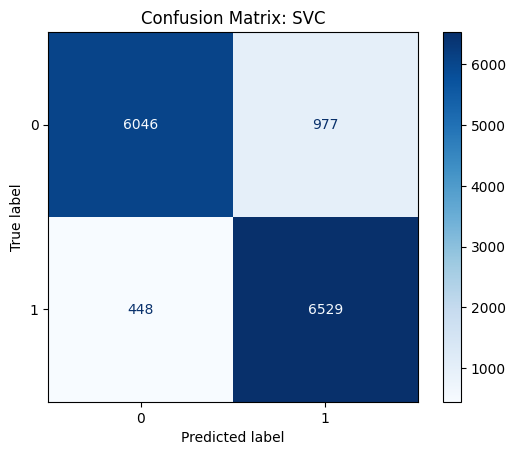

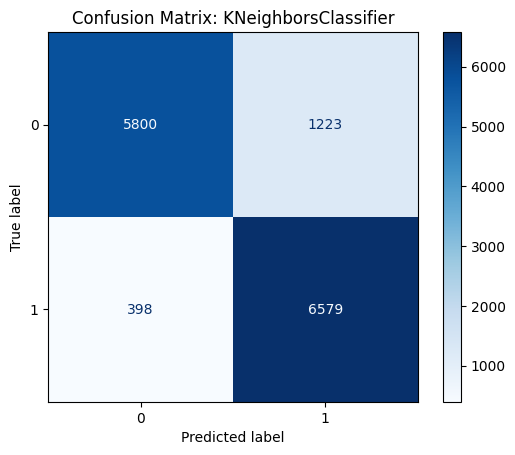

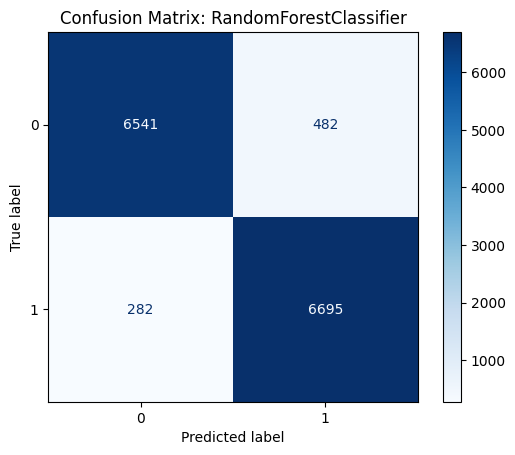

In [38]:
display_confusion_matrix(model_list, performance_balanced)

# Confusion Matrix for Unbalanced Dataset

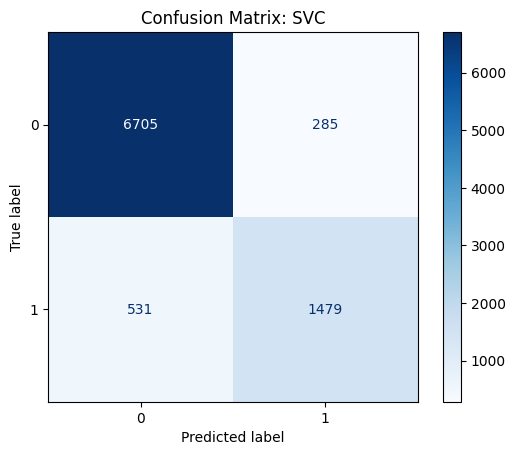

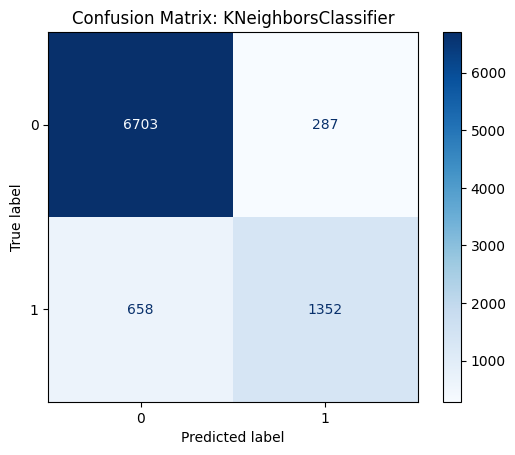

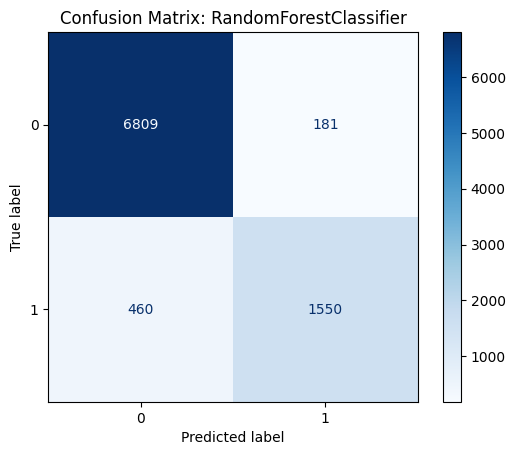

In [39]:
display_confusion_matrix(model_list, performance_unbalanced)

## Comparing the performaces of each model

The performance, as seen from the figure below, is better for balanced dataset as compared to imbalanced dataset

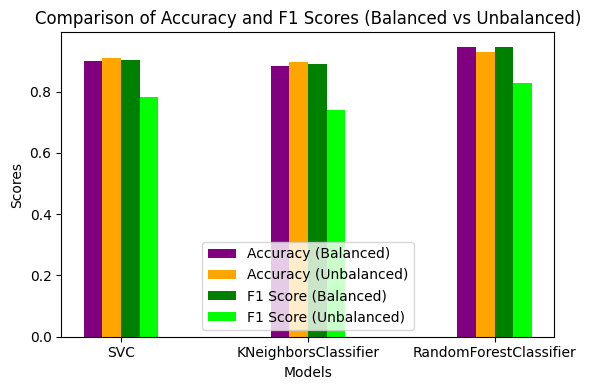

In [48]:
models = list(performance_balanced.keys())
accuracy_balanced = [performance_balanced[model]['accuracy'] for model in models]
accuracy_unbalanced = [performance_unbalanced[model]['accuracy'] for model in models]
f1_balanced = [performance_balanced[model]['f1_score'] for model in models]
f1_unbalanced = [performance_unbalanced[model]['f1_score'] for model in models]

# Bar chart settings
x = np.arange(len(models))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(6, 4))

# Plot accuracy scores
ax.bar(x - width, accuracy_balanced, width, label='Accuracy (Balanced)', color='purple')
ax.bar(x, accuracy_unbalanced, width, label='Accuracy (Unbalanced)', color='orange')

# Plot F1 scores
ax.bar(x + width, f1_balanced, width, label='F1 Score (Balanced)', color='green')
ax.bar(x + 2 * width, f1_unbalanced, width, label='F1 Score (Unbalanced)', color='lime')

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Accuracy and F1 Scores (Balanced vs Unbalanced)')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(models)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()